# **BBM 409: Machine Learning Laboratory -Assignment 1**

**Students:**
- Arda Ceylan: 2220356041
- Arya Zeynep Mete: 2210356104

**Objectives:**

The objective of this project is to develop a comprehensive understanding of key machine learning concepts and classification algorithms using the Scikit-learn library. Specifically, the aim is to:

- Implement and compare K-Nearest Neighbor, Naive Bayes, Random Forest, and Support Vector Machine algorithms on a rice dataset with 106 features and five class labels.
- Apply train-test split and K-Fold Cross Validation to evaluate model performance reliably.
- Experiment with data preprocessing techniques such as scaling and feature elimination to observe their impact on accuracy and inference time.
- Analyze and interpret performance metrics (accuracy, precision, recall, F1-score) and confusion matrices to assess model strengths, weaknesses, and behavior under different scenarios.
- Develop critical insights by tuning hyperparameters, comparing models, and exploring the balance between accuracy and efficiency.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
from PIL import Image
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.utils import shuffle
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif

 # **Used Functions**

tune_models function automates hyperparameter tuning using GridSearchCV to find the best parameters for different models. It takes a dictionary of models, a parameter grid, and training data as input. For each model, if hyperparameters are provided in param_grid, GridSearchCV performs cross-validation and selects the best configuration based on accuracy. If no hyperparameters are specified, the model is trained directly on the data.

In [ ]:
# Function to perform hyperparameter tuning using GridSearchCV, which automates the search for the best hyperparameters

def tune_models(models, param_grid, x_train, y_train):
    best_models = {}
    print("\nHyperparameter Tuning Results:")

    # Loop through each model and apply grid search for hyperparameter tuning
    for name, model in models.items():
        if name in param_grid:
            grid = GridSearchCV(model, param_grid[name], cv=5, scoring='accuracy', n_jobs=-1) # GridSearchCV performs cross-validation to tune hyperparameter
            grid.fit(x_train, y_train)
            best_models[name] = grid.best_estimator_
            print(f"{name}: Best Params = {grid.best_params_}, Best Score = {grid.best_score_:.4f}")
        else:
            model.fit(x_train, y_train) # If no hyperparameters to tune, directly fit the model
            best_models[name] = model

    return best_models

evaluate_models function assesses the performance of trained models on a test dataset. It takes a dictionary of the best models, test data (x_test, y_test), and a feature type label for reference. For each model, it records inference time, predicts outcomes, and calculates key evaluation metrics—accuracy, precision, recall, and F1-score—using classification_report. Additionally, it generates and visualizes a confusion matrix using seaborn and matplotlib to analyze model predictions.

In [ ]:
# Function to evaluate models
def evaluate_models(best_models, x_test, y_test, feature_type):
    print(f"\nTest Set Evaluation ({feature_type} Features):")
    inference_times = {}

    for name, model in best_models.items():
        start_time = time.time()
        y_pred = model.predict(x_test)
        inference_times[name] = time.time() - start_time

        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, average='weighted')
        rec = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')

        print(f"\n{name} Classification Report:")
        print(classification_report(y_test, y_pred))
        print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1-Score: {f1:.4f}")
        print(f"Inference Time: {inference_times[name]:.6f} seconds")

        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix - {name} ({feature_type} Features)')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

    return inference_times

cross_validate_models function evaluates the generalization performance of trained models using k-fold cross-validation. It takes a dictionary of trained models, dataset features (x), labels (y), and the number of folds (cv, default is 5). For each model, it computes cross-validation accuracy scores using cross_val_score, which splits the data into cv subsets, trains the model on cv-1 folds, and tests it on the remaining fold. The function prints the individual cross-validation scores, their average, and the standard deviation.

In [ ]:
# Function to perform cross-validation
def cross_validate_models(best_models, x, y, cv=5):
    print("\nCross-Validation Results:")
    for name, model in best_models.items():
        cv_scores = cross_val_score(model, x, y, cv=cv, scoring='accuracy')
        print("\n" + name)
        print("Cross Validation Scores: ", cv_scores)
        print("Average CV Score: ", cv_scores.mean())
        print("Number of CV Scores used in Average: ", len(cv_scores))
        print(f"Cross-Validation Accuracy: {np.mean(cv_scores):.4f} (±{np.std(cv_scores):.4f})")

 # **Part** 1

## **Basic Exploration**

In [ ]:
# Connection to drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Get files from local
df = pd.read_csv("part_i.csv")

# Get files from drive
# file_path = "/content/drive/My Drive/Colab_Notebooks/part_i.csv"
# df = pd.read_csv(file_path)

# Randomize the data
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# frac=1 means "return all rows" so, it's not actually sampling a subset, but rather shuffling the entire df
# setting random_state to a specific number (like 42) ensures that getting the same random shuffle every time we run the code. if we don't set it, the shuffle will be different each time.
# drop=True tells it to discard the old, jumbled index, so we end up with a clean, new index
# randomizing is important because it prevents bias: if our data is sorted or ordered in a particular way, it can introduce bias into our analysis.
# randomizing ensures that our model doesn't learn any patterns that are simply due to the original order of the data.

In [ ]:
# Let's see the first few rows to get an idea of the dataset structure:
print(df.head()) # Displays the first 5 rows

    AREA  PERIMETER  MAJOR_AXIS  MINOR_AXIS  ECCENTRICITY   EQDIASQ  SOLIDITY  \
0   8218    439.136    206.1916     51.4944        0.9683  102.2912    0.9640   
1   7370    325.474    124.5857     76.0664        0.7920   96.8699    0.9745   
2   6276    310.482    128.5197     62.8644        0.8722   89.3916    0.9860   
3  13772    465.556    195.4033     90.2360        0.8870  132.4200    0.9871   
4   7071    396.710    184.5997     49.4962        0.9634   94.8845    0.9730   

   CONVEX_AREA  EXTENT  ASPECT_RATIO  ...  ALLdaub4L  ALLdaub4a  ALLdaub4b  \
0         8525  0.3898        4.0042  ...   109.5748    65.1390    57.1702   
1         7563  0.6907        1.6379  ...   112.1062    64.2912    62.3958   
2         6365  0.6093        2.0444  ...    96.4829    64.0420    63.2474   
3        13952  0.6394        2.1655  ...   119.7118    64.0333    65.2929   
4         7267  0.6658        3.7296  ...   113.6850    63.2602    60.3894   

   ALLdaub4Y  ALLdaub4Cb  ALLdaub4Cr  ALLdau

In [ ]:
# Learn dataset shape to understand how many samples and features we have:

print(f"Dataset Shape: {df.shape}")  # (rows, columns)

Dataset Shape: (75000, 107)


In [ ]:
# Check column names to see the feature names:

print(df.columns)

Index(['AREA', 'PERIMETER', 'MAJOR_AXIS', 'MINOR_AXIS', 'ECCENTRICITY',
       'EQDIASQ', 'SOLIDITY', 'CONVEX_AREA', 'EXTENT', 'ASPECT_RATIO',
       ...
       'ALLdaub4L', 'ALLdaub4a', 'ALLdaub4b', 'ALLdaub4Y', 'ALLdaub4Cb',
       'ALLdaub4Cr', 'ALLdaub4XX', 'ALLdaub4YY', 'ALLdaub4ZZ', 'CLASS'],
      dtype='object', length=107)


> The data has got 106 features and 1 label.

In [ ]:
# Detect if there are missing values:

print(df.isnull().sum())  # count of missing values per column

AREA            0
PERIMETER       0
MAJOR_AXIS      0
MINOR_AXIS      0
ECCENTRICITY    0
               ..
ALLdaub4Cr      0
ALLdaub4XX      0
ALLdaub4YY      0
ALLdaub4ZZ      0
CLASS           0
Length: 107, dtype: int64


> There is no missing values, so we don't have to handle them.

>> In this part, it's look like this, but we will explain in the later parts of the report that this result is incorrect and why it might be so.

In [ ]:
# Statistical summary to get numerical insights:

print(df.describe())

               AREA     PERIMETER    MAJOR_AXIS    MINOR_AXIS  ECCENTRICITY  \
count  75000.000000  75000.000000  75000.000000  75000.000000  75000.000000   
mean    8379.197507    378.169453    161.805540     66.829335      0.886077   
std     3119.209274     70.597008     36.461005     16.689269      0.071906   
min     3929.000000    261.040000     96.968300     34.673000      0.627700   
25%     6259.000000    316.431500    132.623500     49.650200      0.846100   
50%     7345.000000    351.261000    149.343950     69.183900      0.885600   
75%     8901.000000    444.986000    197.462025     75.814125      0.950800   
max    21019.000000    593.698000    255.647200    113.441100      0.986800   

            EQDIASQ      SOLIDITY   CONVEX_AREA        EXTENT  ASPECT_RATIO  \
count  75000.000000  75000.000000  75000.000000  75000.000000  75000.000000   
mean     101.731251      0.975896   8584.862320      0.633226      2.597063   
std       17.874070      0.007966   3189.298025    

In [ ]:
# And let's see it's datatypes

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75000 entries, 0 to 74999
Columns: 107 entries, AREA to CLASS
dtypes: float64(95), int64(11), object(1)
memory usage: 61.2+ MB
None


## **Data Visualization**

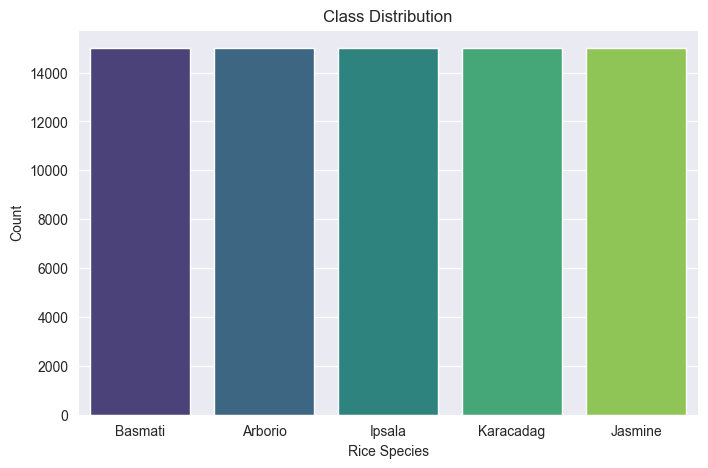

In [ ]:
# Since it's a classification problem, let's see how classes are distributed:

plt.figure(figsize=(8,5))
sns.countplot(x="CLASS", data=df, hue="CLASS", palette="viridis", legend=False)
plt.title("Class Distribution")
plt.xlabel("Rice Species")
plt.ylabel("Count")
plt.show()

> If the dataset is imbalanced, this might affect the model's performance. But we are lucky that the dataset is balanced.

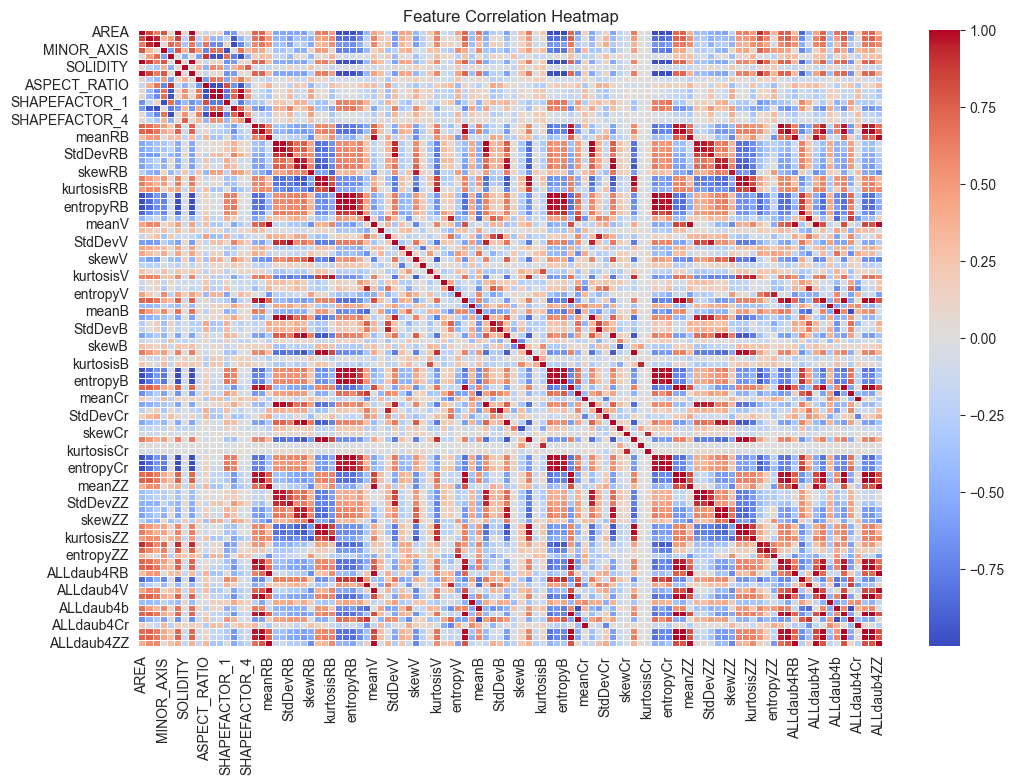

In [ ]:
# Feature Correlation Heatmap to check feature relationships:

plt.figure(figsize=(12,8))

# corr() function only works for numeric values, so we should use only number type columns
numeric_df = df.select_dtypes(include=['number'])

sns.heatmap(numeric_df.corr(), cmap="coolwarm", annot=False, linewidths=0.5)

plt.title("Feature Correlation Heatmap")
plt.show()

> **Interpreting the Feature Correlation Heatmap**

> The diagonal line (from top-left to bottom-right) shows perfect correlation (1.0), because each feature is perfectly correlated with itself.
The colors range from red (strong positive correlation) to blue (strong negative correlation).

> For example **entropyRB and entropyB appear to have high positive correlations** with each other. This suggests that they may be capturing similar information, which could indicate redundancy in the dataset.

> Some feature pairs show strong **negative correlations (e.g., entropyB vs. AREA)**.
This means when one feature increases, the other tends to decrease.


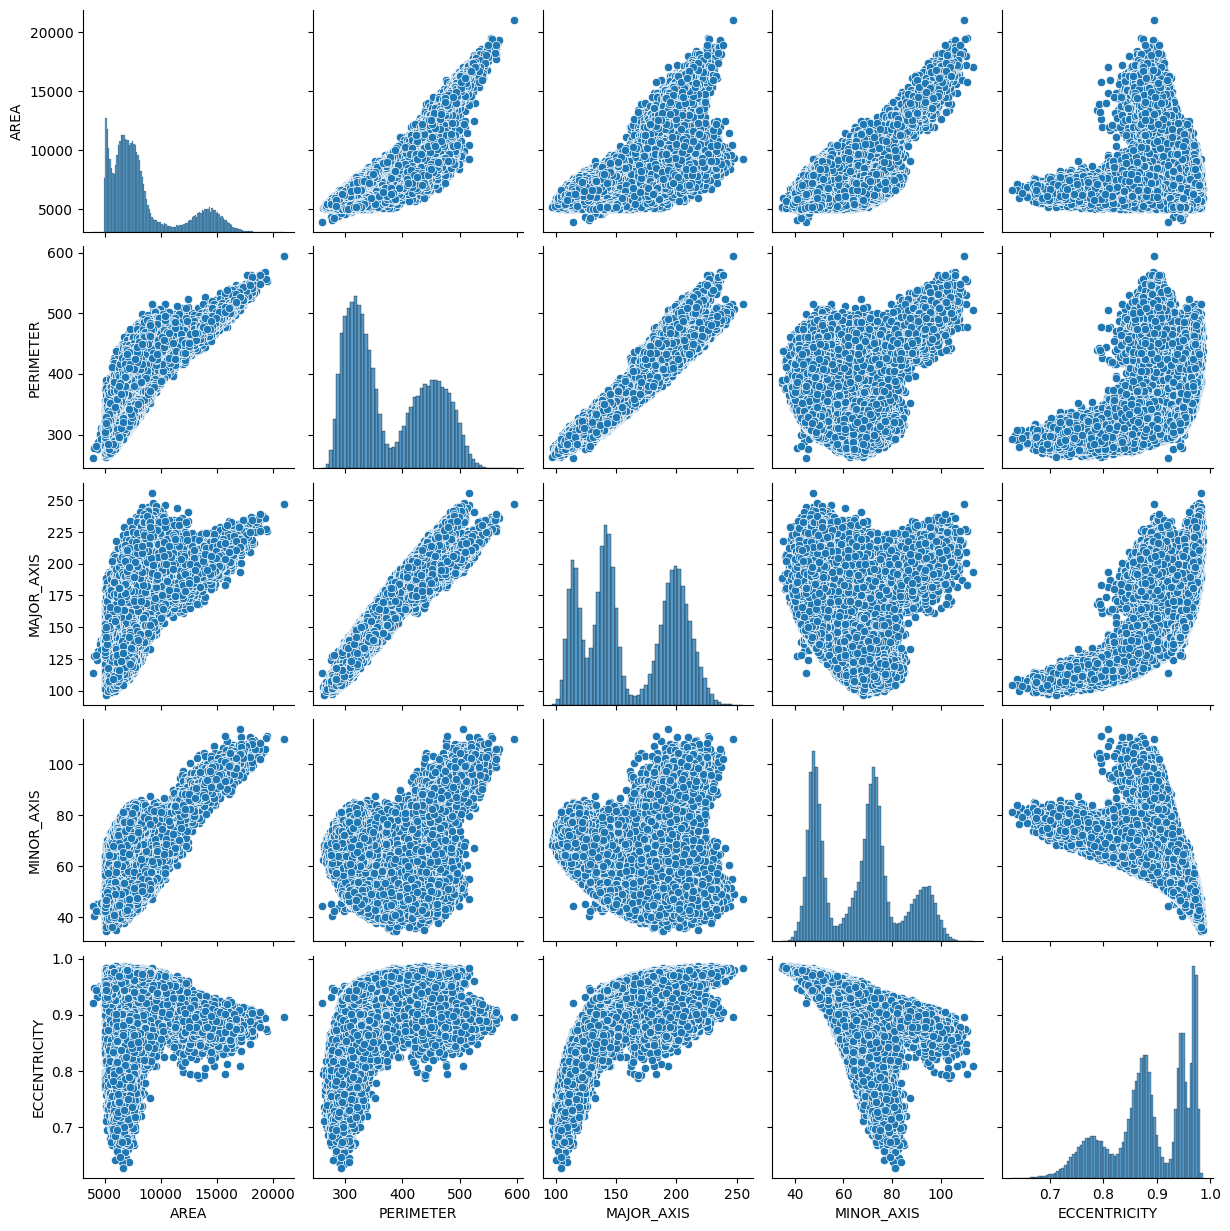

In [ ]:
#Pairplot of some features to visualize relationships:

sns.pairplot(df.iloc[:, :5])  # we have got 106 features and 1 class but let's see 5 features
plt.show()

> Scatter plots:
> For each pair of features, it creates a scatter plot showing how they relate. This helps spot trends or groupings.

> Histograms (diagonal):
On the diagonal, it shows the distribution (e.g., histogram) of each feature — helping you understand how values are spread out.

> Detects correlations:
> - If points form a clear line or curve, those features might be correlated.
For example **PERIMETER and MAJOR_AXIS looks like correlated**.
>- If it's a random cloud, there's likely no strong relationship.

## **Preparing the Data**

In [ ]:
# Split the data into train and test sets randomly (80% train, 20% test)

x = df.drop(columns=['CLASS']) # Features (exclude the target variable "CLASS")
y = df['CLASS'] # Target variable (CLASS)

In [ ]:
# In the code above, we found that there are no NaN values in the dataset. However, during the tune_models step, we encountered a missing values error. This could be due to the following reasons:

# Invisible NaN values: For example, empty strings ("") or other representations of missing data might not be detected by isnull().
# Corrupted Data Types: There could be issues with data types (e.g., objects that might contain NaN-like values but aren't recognized properly).

# So, to fix that error before, we create an imputer to fill missing values with the median
imputer = SimpleImputer(strategy='median')
x = pd.DataFrame(imputer.fit_transform(x), columns=x.columns)

In [ ]:
# Optional: Standardize the features for better performance with some algorithms (e.g., SVM, kNN)
# Standardization helps by scaling the data so that each feature has zero mean and unit variance

scaler = StandardScaler()
x_scaled = pd.DataFrame(scaler.fit_transform(x), columns=x.columns)

In [ ]:
# Feature selection is a process where you choose the most important features from your dataset to improve model performance

# Select top 50 features
selector = SelectKBest(score_func=f_classif, k=50)
x_selected_50 = selector.fit_transform(x, y)

# Select top 50 features with scaled data for best performance
selector = SelectKBest(score_func=f_classif, k=50)
x_scaled_selected_50 = selector.fit_transform(x_scaled, y)

# Try to increase accuracy or reduce complexity with the best data and less feature
# Select top 10 features with scaled data
selector = SelectKBest(score_func=f_classif, k=10)
x_scaled_selected_10 = selector.fit_transform(x_scaled, y)

In [ ]:
# Perform train-test split (80% for training, 20% for testing)
# random_state=42 ensures that the split is reproducible, it's common to keep it consistent for reproducibility

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)
x_train_scaled, x_test_scaled, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=42, stratify=y)
x_train_selected_50, x_test_selected_50, y_train, y_test = train_test_split(x_selected_50, y, test_size=0.2, random_state=42, stratify=y)
x_train_scaled_selected_50, x_test_scaled_selected_50, y_train, y_test = train_test_split(x_scaled_selected_50, y, test_size=0.2, random_state=42, stratify=y)
x_train_scaled_selected_10, x_test_scaled_selected_10, y_train, y_test = train_test_split(x_scaled_selected_10, y, test_size=0.2, random_state=42, stratify=y)

## **Test all models with best params**

K-Nearest Neighbors (KNN): A distance-based algorithm that classifies a data point based on the majority label among its nearest neighbors.

Naive Bayes: A probabilistic classifier based on Bayes’ theorem, particularly effective for text classification and datasets with independent features.

Random Forest: An ensemble learning method that constructs multiple decision trees and combines their outputs to improve accuracy and reduce overfitting.

Support Vector Machine (SVM): Implemented using LinearSVC, which is a linear classifier optimized for large datasets.

LinearSVC is optimized for linear classification and is computationally more efficient for high-dimensional datasets compared to SVC(kernel='linear'). SVC supports multiple kernel types (e.g., RBF, polynomial), but for purely linear decision boundaries, LinearSVC is faster and scales better to large datasets. Also LinearSVC is implemented using the liblinear solver, which is more memory-efficient and handles large-scale data better than SVC.

In [ ]:
# Defining models to be used for classification. Here, we choose some common algorithms
# K-Nearest Neighbors (KNN), Naive Bayes, Random Forest and SVM as classifiers.

models = {
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Support Vector Machine": LinearSVC(random_state=42)
}

'n_neighbors': [3, 5, 7, 9]: The number of nearest neighbors considered for classification.  
<br>

'weights': ['uniform', 'distance']: Determines how neighbors contribute to classification.

'uniform': All neighbors have equal weight.

'distance': Closer neighbors have more influence.  
<br>

'n_estimators': [50, 100]: The number of decision trees in the forest.

More trees generally improve performance but increase computation time.  
<br>

'max_depth': [None, 10]: The maximum depth of each tree.

None: Trees grow until all leaves are pure or have minimum samples.

10: Restricts tree depth to prevent overfitting.

In [ ]:
# Defining a grid of hyperparameters for GridSearchCV to explore. This helps in fine-tuning the models
# by testing different values of hyperparameters and selecting the best performing combination.

param_grid = {
    "K-Nearest Neighbors": {'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance']},
    "Random Forest": {'n_estimators': [50, 100], 'max_depth': [None, 10]},
}

In [ ]:
# Hyperparameter Tuning: This calls the function to tune the models and stores the best ones
best_models = tune_models(models, param_grid, x_train, y_train)


Hyperparameter Tuning Results:
K-Nearest Neighbors: Best Params = {'n_neighbors': 9, 'weights': 'distance'}, Best Score = 0.9251
Random Forest: Best Params = {'max_depth': None, 'n_estimators': 100}, Best Score = 0.9986



Test Set Evaluation (Class Features):

K-Nearest Neighbors Classification Report:
              precision    recall  f1-score   support

     Arborio       0.92      0.94      0.93      3000
     Basmati       0.89      0.84      0.87      3000
      Ipsala       1.00      1.00      1.00      3000
     Jasmine       0.93      0.98      0.95      3000
   Karacadag       0.89      0.87      0.88      3000

    accuracy                           0.93     15000
   macro avg       0.93      0.93      0.93     15000
weighted avg       0.93      0.93      0.93     15000

Accuracy: 0.9261, Precision: 0.9257, Recall: 0.9261, F1-Score: 0.9256
Inference Time: 1.543996 seconds


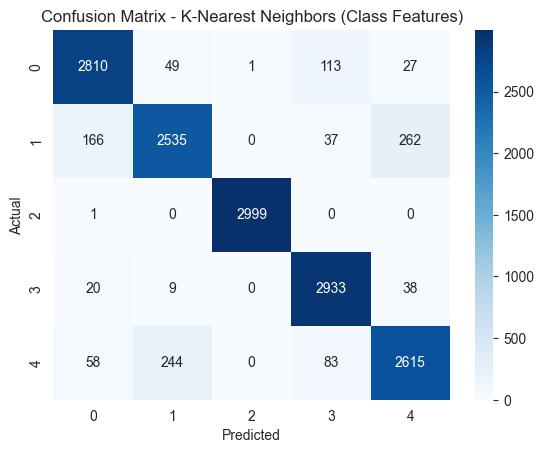


Naive Bayes Classification Report:
              precision    recall  f1-score   support

     Arborio       0.79      0.55      0.65      3000
     Basmati       0.64      0.72      0.68      3000
      Ipsala       0.98      0.99      0.99      3000
     Jasmine       0.90      0.70      0.78      3000
   Karacadag       0.62      0.86      0.72      3000

    accuracy                           0.76     15000
   macro avg       0.79      0.76      0.76     15000
weighted avg       0.79      0.76      0.76     15000

Accuracy: 0.7649, Precision: 0.7856, Recall: 0.7649, F1-Score: 0.7642
Inference Time: 0.093976 seconds


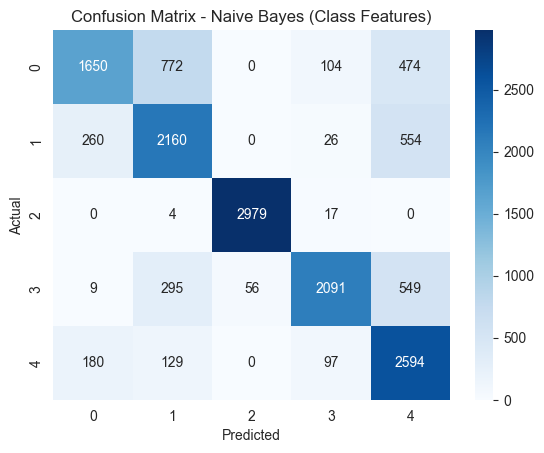


Random Forest Classification Report:
              precision    recall  f1-score   support

     Arborio       1.00      1.00      1.00      3000
     Basmati       1.00      1.00      1.00      3000
      Ipsala       1.00      1.00      1.00      3000
     Jasmine       1.00      1.00      1.00      3000
   Karacadag       1.00      1.00      1.00      3000

    accuracy                           1.00     15000
   macro avg       1.00      1.00      1.00     15000
weighted avg       1.00      1.00      1.00     15000

Accuracy: 0.9989, Precision: 0.9989, Recall: 0.9989, F1-Score: 0.9989
Inference Time: 0.087999 seconds


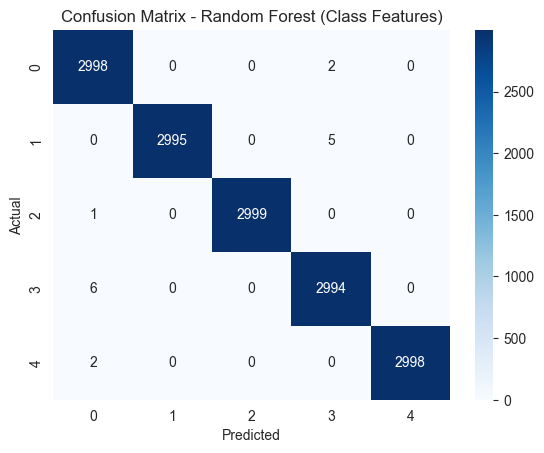


Support Vector Machine Classification Report:
              precision    recall  f1-score   support

     Arborio       0.75      0.89      0.81      3000
     Basmati       0.71      0.80      0.75      3000
      Ipsala       0.99      0.99      0.99      3000
     Jasmine       0.74      0.55      0.63      3000
   Karacadag       0.85      0.79      0.82      3000

    accuracy                           0.80     15000
   macro avg       0.81      0.80      0.80     15000
weighted avg       0.81      0.80      0.80     15000

Accuracy: 0.8049, Precision: 0.8068, Recall: 0.8049, F1-Score: 0.8012
Inference Time: 0.009001 seconds


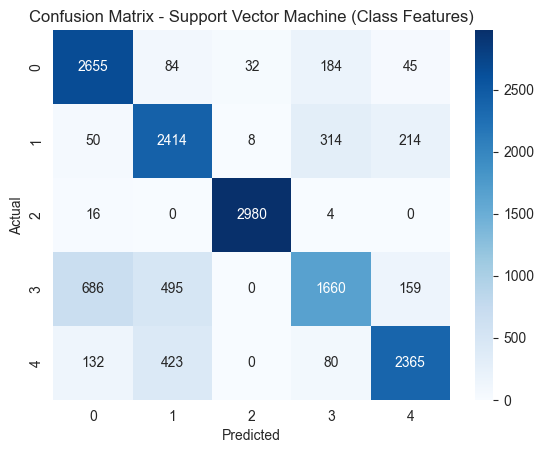

In [ ]:
inference_times = evaluate_models(best_models, x_test, y_test, feature_type="Class")

> Accuracy of the models:
- KNN = 0.93
- Naive Bayes = 0.76
- Random Forest = 0.99
- SVM = 0.80

> K-Nearest Neighbors works well with numerical data, especially when the data has clear clusters — which might be the case with rice types, they’re distinguishable based on texture and grain size.

> Naive Bayes assumes feature independence, which rarely holds true in complex datasets like rice texture data. The lower accuracy indicates the features likely depend on each other, making Naive Bayes less effective.

>Random Forest; the near-perfect score suggests the model benefits from its ensemble nature — combining multiple decision trees reduces overfitting and handles high-dimensional data well. It’s also good with numerical data and can automatically assess feature importance, which might explain its dominance here.

> Support Vector Machine usually performs well on high-dimensional numerical data, but its accuracy here is lower than KNN and Random Forest. This might be due to the dataset not being linearly separable, or the kernel type not fitting the data’s structure perfectly. A more complex kernel or tuning might improve performance.



In [ ]:
k_folds = KFold(n_splits = 5)
cross_validate_models(best_models, x, y, cv=k_folds)


Cross-Validation Results:

K-Nearest Neighbors
Cross Validation Scores:  [0.925      0.92853333 0.9242     0.92513333 0.92613333]
Average CV Score:  0.9258000000000001
Number of CV Scores used in Average:  5
Cross-Validation Accuracy: 0.9258 (±0.0015)

Naive Bayes
Cross Validation Scores:  [0.77033333 0.76666667 0.7648     0.76633333 0.7652    ]
Average CV Score:  0.7666666666666667
Number of CV Scores used in Average:  5
Cross-Validation Accuracy: 0.7667 (±0.0020)

Random Forest
Cross Validation Scores:  [0.99866667 0.99893333 0.99866667 0.99846667 0.99873333]
Average CV Score:  0.9986933333333333
Number of CV Scores used in Average:  5
Cross-Validation Accuracy: 0.9987 (±0.0001)

Support Vector Machine
Cross Validation Scores:  [0.8014     0.80393333 0.80733333 0.81126667 0.80333333]
Average CV Score:  0.8054533333333334
Number of CV Scores used in Average:  5
Cross-Validation Accuracy: 0.8055 (±0.0035)


> Similar results with Train-Test Split.

In [ ]:
# Applying K-Fold Cross-Validation with a different number of split (10)

# In generally,
# K = 2 or 3: beneficial when computational resources are limited, they reduce the number of training cycles
# K = 5 or 10: popular choices because they provide a good balance between computational efficiency and model performance estimation
# K = 20: larger value of K can provide a more detailed performance evaluation but higher variance if the subsets are too small

k_folds = KFold(n_splits = 10)
cross_validate_models(best_models, x, y, cv=k_folds)


Cross-Validation Results:

K-Nearest Neighbors
Cross Validation Scores:  [0.92413333 0.92506667 0.92826667 0.9304     0.9248     0.92533333
 0.93026667 0.92053333 0.9236     0.92906667]
Average CV Score:  0.9261466666666667
Number of CV Scores used in Average:  10
Cross-Validation Accuracy: 0.9261 (±0.0031)

Naive Bayes
Cross Validation Scores:  [0.7676     0.77293333 0.76706667 0.76693333 0.772      0.75906667
 0.77533333 0.7572     0.76506667 0.76333333]
Average CV Score:  0.7666533333333334
Number of CV Scores used in Average:  10
Cross-Validation Accuracy: 0.7667 (±0.0055)

Random Forest
Cross Validation Scores:  [0.99853333 0.99853333 0.9984     0.9996     0.99866667 0.99893333
 0.99813333 0.9988     0.99826667 0.9988    ]
Average CV Score:  0.9986666666666665
Number of CV Scores used in Average:  10
Cross-Validation Accuracy: 0.9987 (±0.0004)

Support Vector Machine
Cross Validation Scores:  [0.80306667 0.80333333 0.81013333 0.8076     0.80573333 0.808
 0.81226667 0.81213333 0.8

> Similar results with 5 splits.

In [ ]:
# Applying K-Fold Cross-Validation with a different number of split (20)

k_folds = KFold(n_splits = 20)
cross_validate_models(best_models, x, y, cv=k_folds)


Cross-Validation Results:

K-Nearest Neighbors
Cross Validation Scores:  [0.92453333 0.92453333 0.92453333 0.9264     0.9272     0.93013333
 0.92693333 0.93333333 0.93413333 0.9152     0.92826667 0.92266667
 0.93173333 0.9296     0.91733333 0.92293333 0.92693333 0.9224
 0.92293333 0.932     ]
Average CV Score:  0.9261866666666666
Number of CV Scores used in Average:  20
Cross-Validation Accuracy: 0.9262 (±0.0048)

Naive Bayes
Cross Validation Scores:  [0.77066667 0.7648     0.76853333 0.77733333 0.77066667 0.76293333
 0.77093333 0.76426667 0.78933333 0.75466667 0.764      0.7552
 0.77866667 0.772      0.74773333 0.76666667 0.77013333 0.75946667
 0.7616     0.76346667]
Average CV Score:  0.7666533333333334
Number of CV Scores used in Average:  20
Cross-Validation Accuracy: 0.7667 (±0.0090)

Random Forest
Cross Validation Scores:  [0.99893333 0.9984     0.9984     0.99866667 0.99813333 0.9992
 1.         0.9992     0.9984     0.99866667 0.9992     0.99866667
 0.99706667 0.99946667 0.999

> Similar results with 5 and 10 splits.

> In our case, K-Fold Cross Validation (with 5, 10, 20 splits) and Train-Test Split all give the same results, it likely indicates:

> Stable and balanced data: The dataset is well-distributed, without major class imbalances or noisy data, leading to consistent performance across different splits.

> Low variance model: The model generalizes well and isn’t overfitting or underfitting, showing consistent accuracy regardless of how the data is split.

>Sufficient data size: Dataset is large enough, but even smaller training subsets still represent the full data distribution accurately.

> Feature effectiveness: The features are strong and distinct enough to help the model separate classes reliably.

> It’s generally a good sign, showing the model is reliable and the data is clean.

In [ ]:
# Find the optimal models
best_model = max(best_models, key=lambda name: accuracy_score(y_test, best_models[name].predict(x_test)))
fastest_inference = min(inference_times, key=inference_times.get)

print("\nBest Model Based on Accuracy For Raw Data:", best_model)
print("Fastest Model in Inference For Raw Data:", fastest_inference, f"({inference_times[fastest_inference]:.6f} seconds)")


Best Model Based on Accuracy For Raw Data: Random Forest
Fastest Model in Inference For Raw Data: Support Vector Machine (0.009001 seconds)


> Random Forest (Best Accuracy): It combines multiple decision trees, reducing overfitting and handling high-dimensional data (106 features) well. It excels at capturing complex patterns in the rice data, leading to high accuracy.

> SVM (Fastest Inference): Once trained, SVM mainly relies on the support vectors (a subset of data points) for predictions — not the entire dataset. This makes inference extremely fast, especially for numerical, high-dimensional data like ours. However, training SVM can be slower, but inference remains quick.

## **Experiments with Raw Data, Scaled Data and Eliminated Data**


Hyperparameter Tuning Results:
K-Nearest Neighbors: Best Params = {'n_neighbors': 3, 'weights': 'uniform'}, Best Score = 0.9977
Random Forest: Best Params = {'max_depth': None, 'n_estimators': 100}, Best Score = 0.9986

Test Set Evaluation (Class Features):

K-Nearest Neighbors Classification Report:
              precision    recall  f1-score   support

     Arborio       1.00      1.00      1.00      3000
     Basmati       1.00      1.00      1.00      3000
      Ipsala       1.00      1.00      1.00      3000
     Jasmine       1.00      1.00      1.00      3000
   Karacadag       1.00      1.00      1.00      3000

    accuracy                           1.00     15000
   macro avg       1.00      1.00      1.00     15000
weighted avg       1.00      1.00      1.00     15000

Accuracy: 0.9983, Precision: 0.9983, Recall: 0.9983, F1-Score: 0.9983
Inference Time: 1.646238 seconds


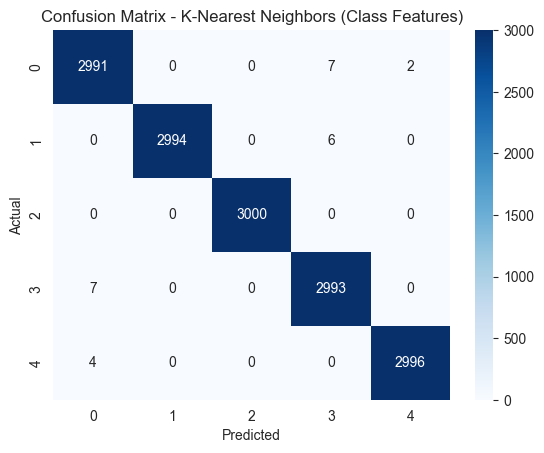


Naive Bayes Classification Report:
              precision    recall  f1-score   support

     Arborio       0.99      0.99      0.99      3000
     Basmati       1.00      0.98      0.99      3000
      Ipsala       1.00      1.00      1.00      3000
     Jasmine       0.97      1.00      0.98      3000
   Karacadag       0.99      1.00      1.00      3000

    accuracy                           0.99     15000
   macro avg       0.99      0.99      0.99     15000
weighted avg       0.99      0.99      0.99     15000

Accuracy: 0.9920, Precision: 0.9921, Recall: 0.9920, F1-Score: 0.9920
Inference Time: 0.067090 seconds


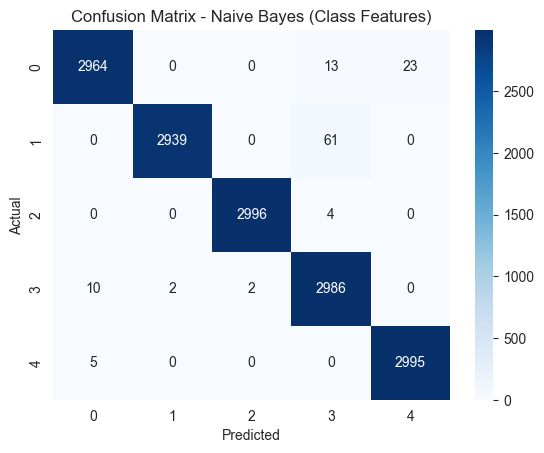


Random Forest Classification Report:
              precision    recall  f1-score   support

     Arborio       1.00      1.00      1.00      3000
     Basmati       1.00      1.00      1.00      3000
      Ipsala       1.00      1.00      1.00      3000
     Jasmine       1.00      1.00      1.00      3000
   Karacadag       1.00      1.00      1.00      3000

    accuracy                           1.00     15000
   macro avg       1.00      1.00      1.00     15000
weighted avg       1.00      1.00      1.00     15000

Accuracy: 0.9989, Precision: 0.9989, Recall: 0.9989, F1-Score: 0.9989
Inference Time: 0.087981 seconds


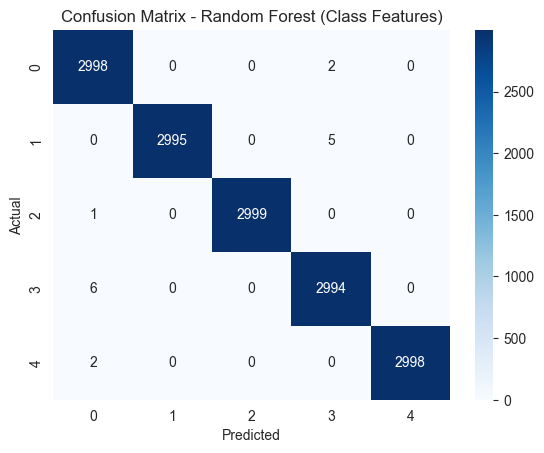


Support Vector Machine Classification Report:
              precision    recall  f1-score   support

     Arborio       1.00      1.00      1.00      3000
     Basmati       1.00      1.00      1.00      3000
      Ipsala       1.00      1.00      1.00      3000
     Jasmine       1.00      1.00      1.00      3000
   Karacadag       1.00      1.00      1.00      3000

    accuracy                           1.00     15000
   macro avg       1.00      1.00      1.00     15000
weighted avg       1.00      1.00      1.00     15000

Accuracy: 0.9993, Precision: 0.9993, Recall: 0.9993, F1-Score: 0.9993
Inference Time: 0.006977 seconds


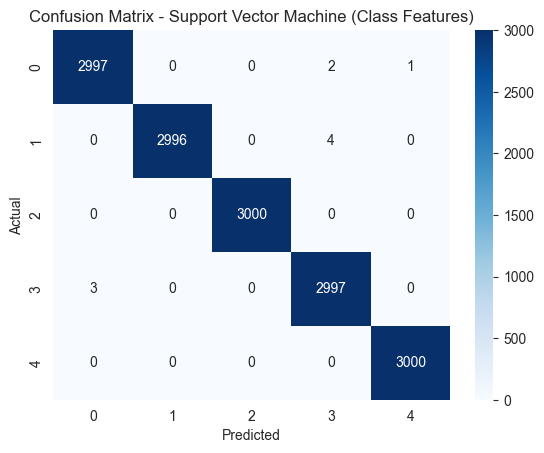


Best Model Based on Accuracy For Scaled Data: Support Vector Machine
Fastest Model in Inference For Scaled Data: Support Vector Machine (0.006977 seconds)


In [ ]:
# In the above part we used Raw Data

# Scaled data
best_models = tune_models(models, param_grid, x_train_scaled, y_train)
inference_times = evaluate_models(best_models, x_test_scaled, y_test, feature_type="Class")

best_model = max(best_models, key=lambda name: accuracy_score(y_test, best_models[name].predict(x_test_scaled)))
fastest_inference = min(inference_times, key=inference_times.get)

print("\nBest Model Based on Accuracy For Scaled Data:", best_model)
print("Fastest Model in Inference For Scaled Data:", fastest_inference, f"({inference_times[fastest_inference]:.6f} seconds)")

> When we scale the data and all accuracies jump to 0.99:

> Distance-based models improve: KNN and SVM rely on distance calculations. Scaling ensures all features contribute equally, preventing larger features from dominating.

> Decision boundaries become clearer: Models like SVM and Random Forest benefit from more balanced feature ranges, helping them find better, more generalized splits.

> Numerical consistency: For rice data with 106 features, scaling reduces variance between features, improving convergence and reducing noise sensitivity.


Hyperparameter Tuning Results:
K-Nearest Neighbors: Best Params = {'n_neighbors': 9, 'weights': 'distance'}, Best Score = 0.9251
Random Forest: Best Params = {'max_depth': None, 'n_estimators': 50}, Best Score = 0.9981

Test Set Evaluation (Class Features):

K-Nearest Neighbors Classification Report:
              precision    recall  f1-score   support

     Arborio       0.92      0.94      0.93      3000
     Basmati       0.89      0.84      0.87      3000
      Ipsala       1.00      1.00      1.00      3000
     Jasmine       0.93      0.98      0.95      3000
   Karacadag       0.89      0.87      0.88      3000

    accuracy                           0.93     15000
   macro avg       0.93      0.93      0.93     15000
weighted avg       0.93      0.93      0.93     15000

Accuracy: 0.9261, Precision: 0.9257, Recall: 0.9261, F1-Score: 0.9256
Inference Time: 0.902519 seconds


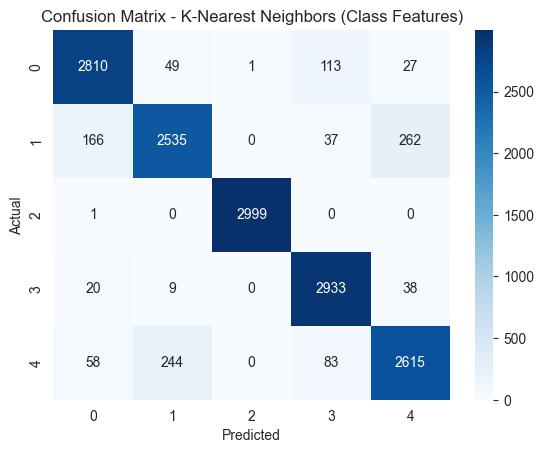


Naive Bayes Classification Report:
              precision    recall  f1-score   support

     Arborio       0.79      0.55      0.65      3000
     Basmati       0.64      0.72      0.68      3000
      Ipsala       0.98      0.99      0.99      3000
     Jasmine       0.90      0.70      0.78      3000
   Karacadag       0.62      0.86      0.72      3000

    accuracy                           0.77     15000
   macro avg       0.79      0.77      0.76     15000
weighted avg       0.79      0.77      0.76     15000

Accuracy: 0.7650, Precision: 0.7856, Recall: 0.7650, F1-Score: 0.7643
Inference Time: 0.036999 seconds


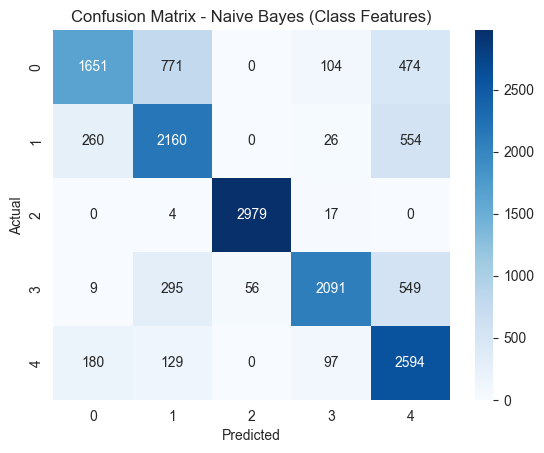


Random Forest Classification Report:
              precision    recall  f1-score   support

     Arborio       1.00      1.00      1.00      3000
     Basmati       1.00      1.00      1.00      3000
      Ipsala       1.00      1.00      1.00      3000
     Jasmine       1.00      1.00      1.00      3000
   Karacadag       1.00      1.00      1.00      3000

    accuracy                           1.00     15000
   macro avg       1.00      1.00      1.00     15000
weighted avg       1.00      1.00      1.00     15000

Accuracy: 0.9987, Precision: 0.9987, Recall: 0.9987, F1-Score: 0.9987
Inference Time: 0.038008 seconds


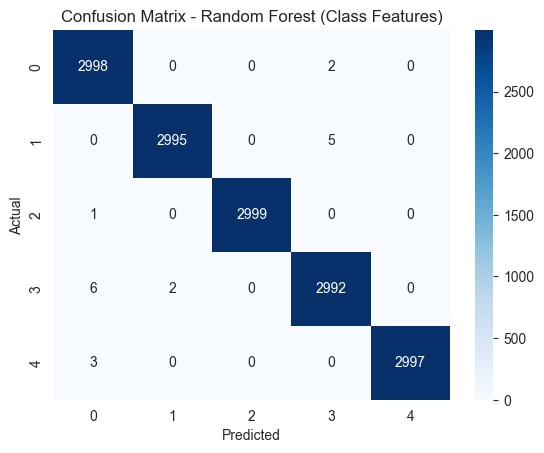


Support Vector Machine Classification Report:
              precision    recall  f1-score   support

     Arborio       0.76      0.88      0.82      3000
     Basmati       0.70      0.80      0.75      3000
      Ipsala       0.99      0.99      0.99      3000
     Jasmine       0.74      0.56      0.64      3000
   Karacadag       0.85      0.79      0.82      3000

    accuracy                           0.81     15000
   macro avg       0.81      0.81      0.80     15000
weighted avg       0.81      0.81      0.80     15000

Accuracy: 0.8052, Precision: 0.8071, Recall: 0.8052, F1-Score: 0.8018
Inference Time: 0.002987 seconds


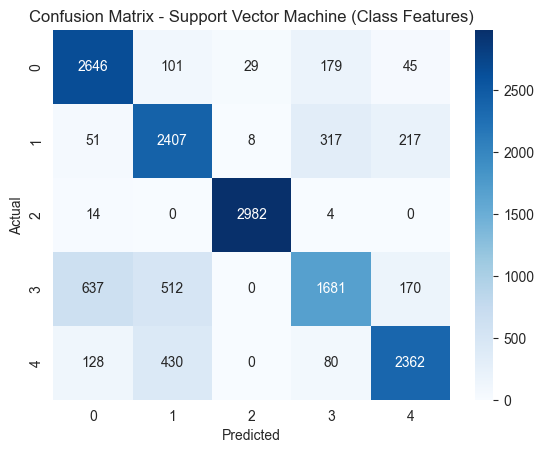


Best Model Based on Accuracy For Eliminated Data(50 Features): Random Forest
Fastest Model in Inference For Eliminated Data(50 Features): Support Vector Machine (0.002987 seconds)


In [ ]:
# Eliminated Data
# Top 50 features
best_models = tune_models(models, param_grid, x_train_selected_50, y_train)
inference_times = evaluate_models(best_models, x_test_selected_50, y_test, feature_type="Class")

best_model = max(best_models, key=lambda name: accuracy_score(y_test, best_models[name].predict(x_test_selected_50)))
fastest_inference = min(inference_times, key=inference_times.get)

print("\nBest Model Based on Accuracy For Eliminated Data(50 Features):", best_model)
print("Fastest Model in Inference For Eliminated Data(50 Features):", fastest_inference, f"({inference_times[fastest_inference]:.6f} seconds)")

> The eliminated dataset (50 features) has the same accuracy as the raw data (106 features) but runs faster than both the raw (0.009001 seconds) and scaled(0.006977 seconds) versions, especially in inference time (0.002987 seconds).

> Why:

> Fewer features = fewer computations: SVM relies on distance calculations and complex math during inference. Reducing features directly cuts the number of calculations, leading to faster predictions.

> Same accuracy despite fewer features: The remaining 50 features likely hold the most valuable information for distinguishing rice types, so the model performs just as well without the extra (less useful) data.

> Scaling helps but doesn’t cut dimensions: Scaling optimizes how features contribute to the model but doesn’t reduce the number of features —so it’s still slower than the eliminated dataset.


Hyperparameter Tuning Results:
K-Nearest Neighbors: Best Params = {'n_neighbors': 9, 'weights': 'uniform'}, Best Score = 0.9983
Random Forest: Best Params = {'max_depth': None, 'n_estimators': 50}, Best Score = 0.9981

Test Set Evaluation (Class Features):

K-Nearest Neighbors Classification Report:
              precision    recall  f1-score   support

     Arborio       1.00      1.00      1.00      3000
     Basmati       1.00      1.00      1.00      3000
      Ipsala       1.00      1.00      1.00      3000
     Jasmine       1.00      1.00      1.00      3000
   Karacadag       1.00      1.00      1.00      3000

    accuracy                           1.00     15000
   macro avg       1.00      1.00      1.00     15000
weighted avg       1.00      1.00      1.00     15000

Accuracy: 0.9987, Precision: 0.9987, Recall: 0.9987, F1-Score: 0.9987
Inference Time: 0.921000 seconds


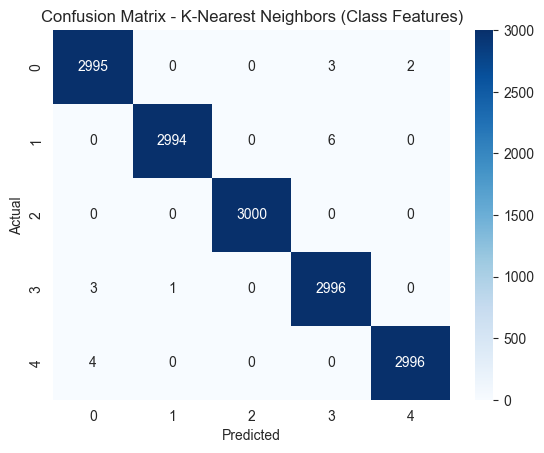


Naive Bayes Classification Report:
              precision    recall  f1-score   support

     Arborio       1.00      0.98      0.99      3000
     Basmati       0.99      0.98      0.99      3000
      Ipsala       1.00      1.00      1.00      3000
     Jasmine       0.98      0.99      0.98      3000
   Karacadag       0.99      1.00      0.99      3000

    accuracy                           0.99     15000
   macro avg       0.99      0.99      0.99     15000
weighted avg       0.99      0.99      0.99     15000

Accuracy: 0.9902, Precision: 0.9902, Recall: 0.9902, F1-Score: 0.9902
Inference Time: 0.039006 seconds


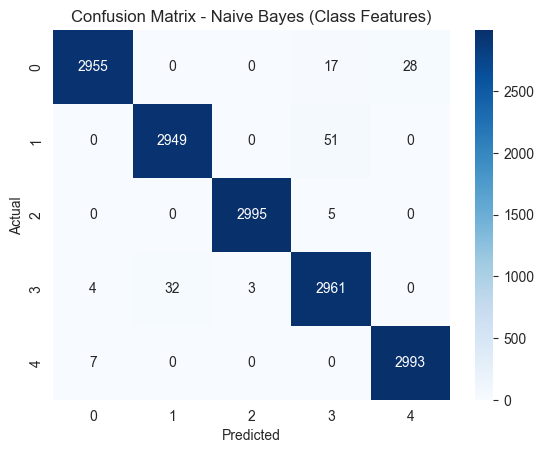


Random Forest Classification Report:
              precision    recall  f1-score   support

     Arborio       1.00      1.00      1.00      3000
     Basmati       1.00      1.00      1.00      3000
      Ipsala       1.00      1.00      1.00      3000
     Jasmine       1.00      1.00      1.00      3000
   Karacadag       1.00      1.00      1.00      3000

    accuracy                           1.00     15000
   macro avg       1.00      1.00      1.00     15000
weighted avg       1.00      1.00      1.00     15000

Accuracy: 0.9987, Precision: 0.9987, Recall: 0.9987, F1-Score: 0.9987
Inference Time: 0.039996 seconds


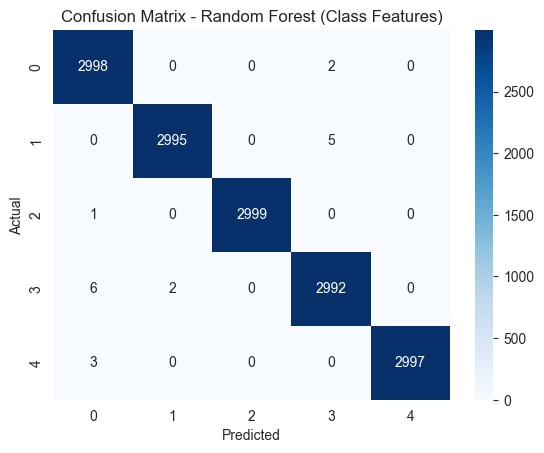


Support Vector Machine Classification Report:
              precision    recall  f1-score   support

     Arborio       1.00      1.00      1.00      3000
     Basmati       1.00      1.00      1.00      3000
      Ipsala       1.00      1.00      1.00      3000
     Jasmine       1.00      1.00      1.00      3000
   Karacadag       1.00      1.00      1.00      3000

    accuracy                           1.00     15000
   macro avg       1.00      1.00      1.00     15000
weighted avg       1.00      1.00      1.00     15000

Accuracy: 0.9989, Precision: 0.9989, Recall: 0.9989, F1-Score: 0.9989
Inference Time: 0.002001 seconds


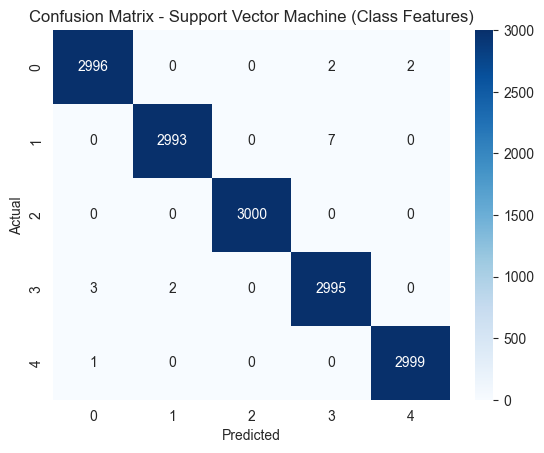


Best Model Based on Accuracy For Scaled-Eliminated Data(50 Features): Support Vector Machine
Fastest Model in Inference For Scaled-Eliminated Data(50 Features): Support Vector Machine (0.002001 seconds)


In [ ]:
# Top 50 features with scaled data
best_models = tune_models(models, param_grid, x_train_scaled_selected_50, y_train)
inference_times = evaluate_models(best_models, x_test_scaled_selected_50, y_test, feature_type="Class")

best_model = max(best_models, key=lambda name: accuracy_score(y_test, best_models[name].predict(x_test_scaled_selected_50)))
fastest_inference = min(inference_times, key=inference_times.get)

print("\nBest Model Based on Accuracy For Scaled-Eliminated Data(50 Features):", best_model)
print("Fastest Model in Inference For Scaled-Eliminated Data(50 Features):", fastest_inference, f"({inference_times[fastest_inference]:.6f} seconds)")

> The scaled-eliminated dataset keeps only the most important 50 features, reducing computation while scaling ensures balanced feature influence —resulting in SVM maintaining high accuracy (0.99) with faster inference(0.002001 seconds) due to fewer inputs.


Hyperparameter Tuning Results:
K-Nearest Neighbors: Best Params = {'n_neighbors': 3, 'weights': 'distance'}, Best Score = 0.9915
Random Forest: Best Params = {'max_depth': None, 'n_estimators': 100}, Best Score = 0.9913

Test Set Evaluation (Class Features):

K-Nearest Neighbors Classification Report:
              precision    recall  f1-score   support

     Arborio       0.99      0.99      0.99      3000
     Basmati       1.00      0.99      0.99      3000
      Ipsala       1.00      1.00      1.00      3000
     Jasmine       0.99      0.99      0.99      3000
   Karacadag       0.99      0.99      0.99      3000

    accuracy                           0.99     15000
   macro avg       0.99      0.99      0.99     15000
weighted avg       0.99      0.99      0.99     15000

Accuracy: 0.9931, Precision: 0.9931, Recall: 0.9931, F1-Score: 0.9931
Inference Time: 0.186006 seconds


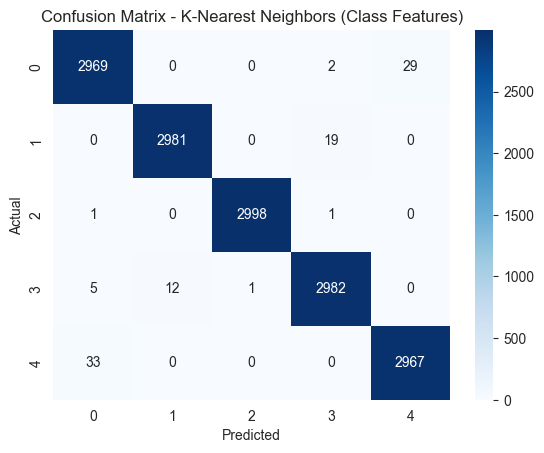


Naive Bayes Classification Report:
              precision    recall  f1-score   support

     Arborio       0.97      0.97      0.97      3000
     Basmati       0.97      0.96      0.97      3000
      Ipsala       1.00      0.99      1.00      3000
     Jasmine       0.95      0.97      0.96      3000
   Karacadag       0.97      0.97      0.97      3000

    accuracy                           0.97     15000
   macro avg       0.97      0.97      0.97     15000
weighted avg       0.97      0.97      0.97     15000

Accuracy: 0.9729, Precision: 0.9730, Recall: 0.9729, F1-Score: 0.9729
Inference Time: 0.010000 seconds


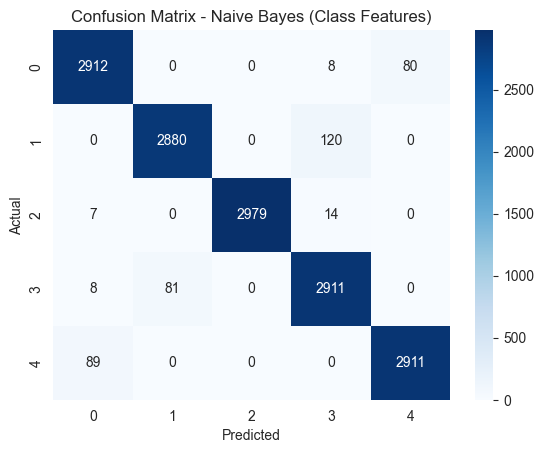


Random Forest Classification Report:
              precision    recall  f1-score   support

     Arborio       0.99      0.99      0.99      3000
     Basmati       0.99      0.99      0.99      3000
      Ipsala       1.00      1.00      1.00      3000
     Jasmine       0.99      0.99      0.99      3000
   Karacadag       0.99      0.99      0.99      3000

    accuracy                           0.99     15000
   macro avg       0.99      0.99      0.99     15000
weighted avg       0.99      0.99      0.99     15000

Accuracy: 0.9933, Precision: 0.9933, Recall: 0.9933, F1-Score: 0.9933
Inference Time: 0.088003 seconds


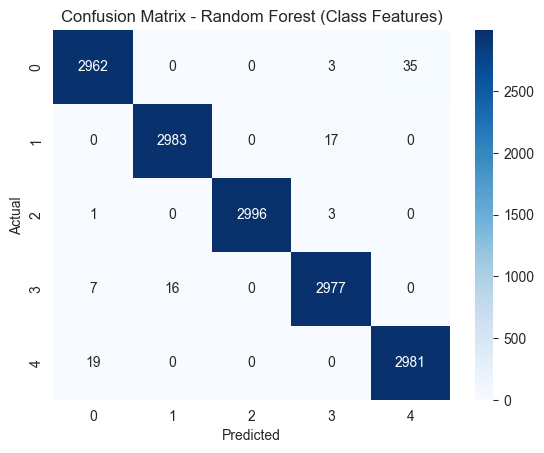


Support Vector Machine Classification Report:
              precision    recall  f1-score   support

     Arborio       0.99      0.99      0.99      3000
     Basmati       1.00      0.99      0.99      3000
      Ipsala       1.00      1.00      1.00      3000
     Jasmine       0.98      0.99      0.99      3000
   Karacadag       0.99      0.99      0.99      3000

    accuracy                           0.99     15000
   macro avg       0.99      0.99      0.99     15000
weighted avg       0.99      0.99      0.99     15000

Accuracy: 0.9908, Precision: 0.9908, Recall: 0.9908, F1-Score: 0.9908
Inference Time: 0.001002 seconds


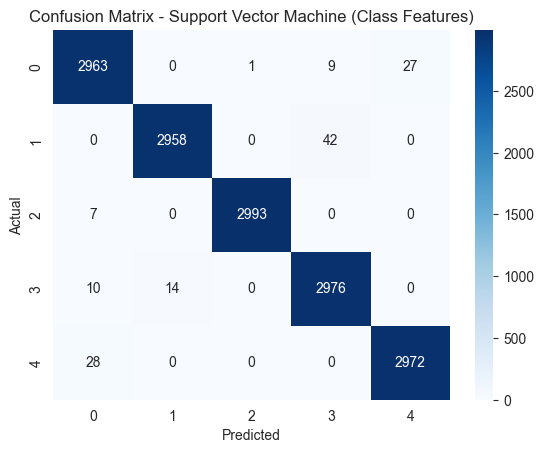


Best Model Based on Accuracy For Scaled-Eliminated Data(10 Features): Random Forest
Fastest Model in Inference For Scaled-Eliminated Data(10 Features): Support Vector Machine (0.001002 seconds)


In [ ]:
# Top 10 features with scaled data
best_models = tune_models(models, param_grid, x_train_scaled_selected_10, y_train)
inference_times = evaluate_models(best_models, x_test_scaled_selected_10, y_test, feature_type="Class")

best_model = max(best_models, key=lambda name: accuracy_score(y_test, best_models[name].predict(x_test_scaled_selected_10)))
fastest_inference = min(inference_times, key=inference_times.get)

print("\nBest Model Based on Accuracy For Scaled-Eliminated Data(10 Features):", best_model)
print("Fastest Model in Inference For Scaled-Eliminated Data(10 Features):", fastest_inference, f"({inference_times[fastest_inference]:.6f} seconds)")

> With only 10 features, the model runs much faster(0.001002 seconds) because it processes less data, but accuracy drops (0.005-0.03) since too many features are removed, causing the model to lose some important information for distinguishing rice types.

 # **Part 2**

## Purpose of the Experiment
- The goal of this project is to classify rice species using various machine learning algorithms, including K-Nearest Neighbors, Naive Bayes, Random Forest, and Support Vector Machines. [DÜZENLENİCEK]


## **Preparing the Data**

In [ ]:
def load_images(image_dir):
    images = []
    labels = []
    for label in os.listdir(image_dir):
        label_dir = os.path.join(image_dir, label)
        for image_name in os.listdir(label_dir):
            img_path = os.path.join(label_dir, image_name)
            img = Image.open(img_path).convert('RGB')  # Open image and convert to RGB
            img_resized = img.resize((16, 16))  # Resize image
            # Smaller images speed up training without losing significant details
            images.append(np.array(img_resized))  # Convert to numpy array
            labels.append(label)
    return np.array(images), np.array(labels)

> RGB Conversion: Converts images to a consistent color format (3 channels — Red, Green, Blue). This ensures uniform data input, especially when images may have different modes (e.g., grayscale or RGBA). It also retains color information, which can be important for distinguishing patterns.

> Resizing (16x16): Reduces image dimensions to lower the computational cost and memory usage while training models. Smaller images speed up processing and model training, though it's a trade-off between detail and efficiency — for classification, basic patterns and shapes may still be recognizable even with low resolution.

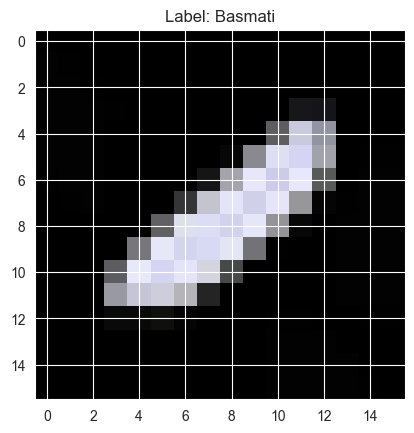

In [ ]:
images, labels = load_images('part_ii')
images, labels = shuffle(images, labels, random_state=42)
plt.imshow(images[0])
plt.title(f"Label: {labels[0]}")
plt.show()

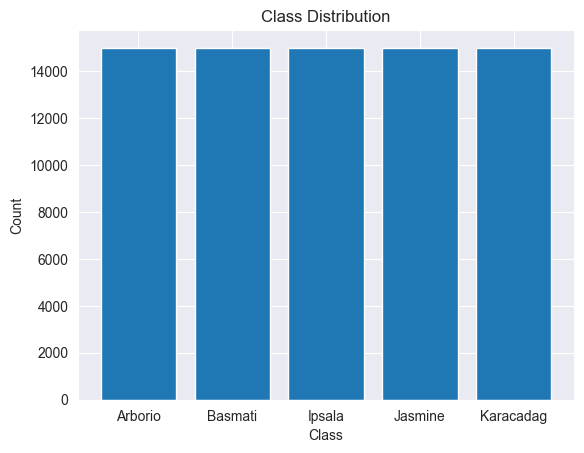

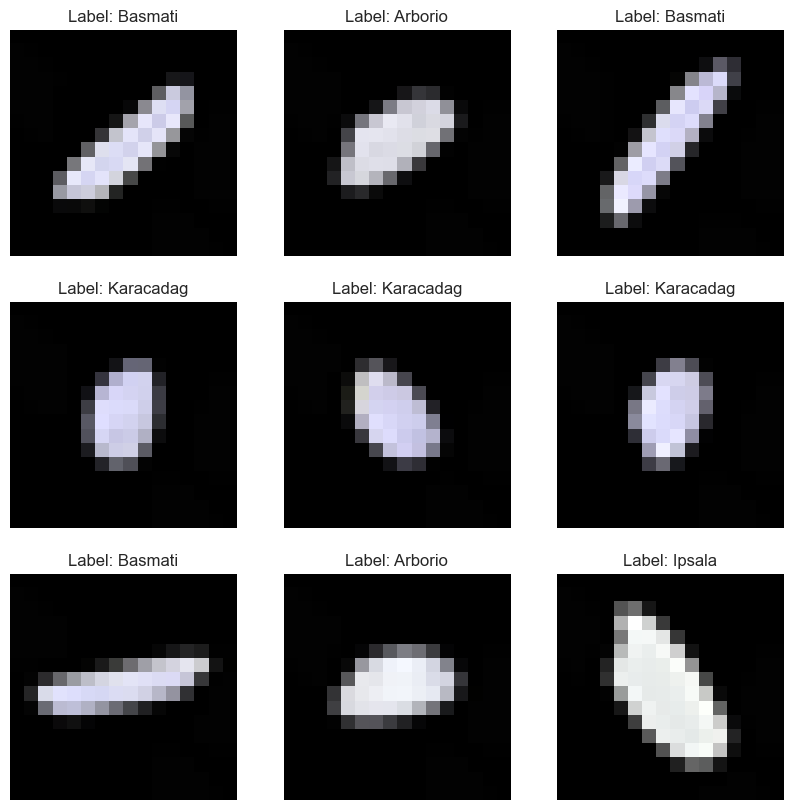

In [ ]:
# Visualize class distribution
unique_labels, counts = np.unique(labels, return_counts=True)
plt.bar(unique_labels, counts)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Visualize sample images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(f"Label: {labels[i]}")
    plt.axis('off')
plt.show()

In [ ]:
# Extract features
x_raw = images.reshape(images.shape[0], -1) # Raw RGB features

# Threshold to binary
threshold = 128
binary_images = (images > threshold).astype(int)
x_binary = binary_images.reshape(binary_images.shape[0], -1) # Binary thresholded features

# Split raw RGB features
x_train_raw, x_test_raw, y_train_raw, y_test_raw = train_test_split(x_raw, labels, test_size=0.2, random_state=42, stratify=labels)

# Split binary thresholded features
x_train_binary, x_test_binary, y_train_binary, y_test_binary = train_test_split(x_binary, labels, test_size=0.2, random_state=42, stratify=labels)

> Reshape:
Flattens the 3D image array (height, width, channels) into a 2D array (samples, features). This makes it suitable for machine learning models, as most models expect a 2D input format.

> Thresholding to Binary:
Converts each pixel value into a binary format (0 or 1) based on a set threshold. This simplifies the data representation and can be useful for tasks where only the presence or absence of certain features is important (e.g., edge detection, feature presence).

> Train-Test Split:
Splits the data into training and testing sets. It randomly divides the dataset, ensuring that 80% of the data is used for training and 20% for testing. The stratify=labels argument ensures that the class distribution in both sets is the same, preventing any class imbalance issues.

## **Test all models with best params**

In [ ]:
# Defining models to be used for classification. Here, we choose some common algorithms
# K-Nearest Neighbors (KNN), Random Forest and SVM as classifiers.

models = {
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Support Vector Machine": LinearSVC(random_state=42)
}

> K-Nearest Neighbors (KNN): A distance-based algorithm that classifies a data point based on the majority label among its nearest neighbors.

> Random Forest: An ensemble learning method that constructs multiple decision trees and combines their outputs to improve accuracy and reduce overfitting.

> Support Vector Machine (SVM): Implemented using LinearSVC, which is a linear classifier optimized for large datasets.  
<br>

> Naive Bayes is not suitable for image classification because:

- It assumes feature independence, meaning each pixel or feature contributes independently to classification. However, in images, neighboring pixels are highly correlated. This assumption breaks, leading to poor performance.

- Naive Bayes treats each pixel as a separate input, ignoring spatial relationships — crucial for recognizing objects in images.

- Images are high-dimensional (exp. 100x100 pixels = 10,000 features). Naive Bayes struggles to handle this without oversimplifying the data, leading to underfitting.

- It works best with categorical or text-based data rather than continuous-valued image features.

- Standard Naive Bayes (like Gaussian) assumes a normal distribution for features. Pixel values rarely follow this distribution, making predictions inaccurate.


In [ ]:
# Defining a grid of hyperparameters for GridSearchCV to explore. This helps in fine-tuning the models
# by testing different values of hyperparameters and selecting the best performing combination.

param_grid = {
    "K-Nearest Neighbors": {'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance']},
    "Random Forest": {'n_estimators': [50, 100], 'max_depth': [None, 10]},
}

'n_neighbors': [3, 5, 7, 9]: The number of nearest neighbors considered for classification.  
<br>

'weights': ['uniform', 'distance']: Determines how neighbors contribute to classification.

'uniform': All neighbors have equal weight.

'distance': Closer neighbors have more influence.  
<br>

'n_estimators': [50, 100]: The number of decision trees in the forest.

More trees generally improve performance but increase computation time.  
<br>

'max_depth': [None, 10]: The maximum depth of each tree.

None: Trees grow until all leaves are pure or have minimum samples.

10: Restricts tree depth to prevent overfitting.

In [ ]:
# Tune models for raw RGB features
best_models_raw = tune_models(models, param_grid, x_train_raw, y_train_raw)


Hyperparameter Tuning Results:
K-Nearest Neighbors: Best Params = {'n_neighbors': 3, 'weights': 'distance'}, Best Score = 0.9776
Random Forest: Best Params = {'max_depth': None, 'n_estimators': 100}, Best Score = 0.9885


In [ ]:
# Tune models for binary thresholded features
best_models_binary = tune_models(models, param_grid, x_train_binary, y_train_binary)


Hyperparameter Tuning Results:
K-Nearest Neighbors: Best Params = {'n_neighbors': 7, 'weights': 'uniform'}, Best Score = 0.9498
Random Forest: Best Params = {'max_depth': None, 'n_estimators': 50}, Best Score = 0.9551



Test Set Evaluation (Raw RGB Features):

K-Nearest Neighbors Classification Report:
              precision    recall  f1-score   support

     Arborio       0.98      0.96      0.97      3000
     Basmati       0.97      0.98      0.97      3000
      Ipsala       1.00      0.99      1.00      3000
     Jasmine       0.97      0.97      0.97      3000
   Karacadag       0.97      0.99      0.98      3000

    accuracy                           0.98     15000
   macro avg       0.98      0.98      0.98     15000
weighted avg       0.98      0.98      0.98     15000

Accuracy: 0.9775, Precision: 0.9776, Recall: 0.9775, F1-Score: 0.9775
Inference Time: 14.834177 seconds


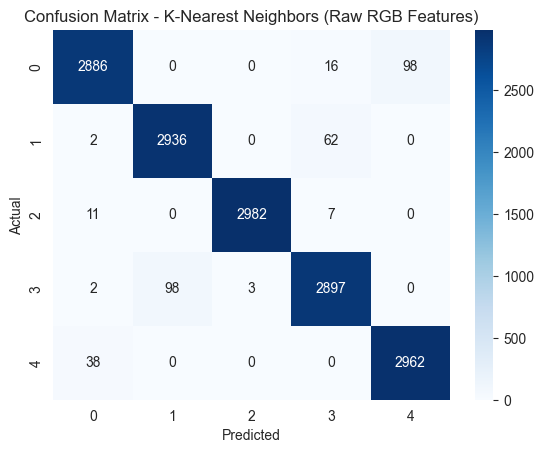


Random Forest Classification Report:
              precision    recall  f1-score   support

     Arborio       0.99      0.99      0.99      3000
     Basmati       0.99      0.99      0.99      3000
      Ipsala       1.00      1.00      1.00      3000
     Jasmine       0.98      0.99      0.98      3000
   Karacadag       0.99      0.99      0.99      3000

    accuracy                           0.99     15000
   macro avg       0.99      0.99      0.99     15000
weighted avg       0.99      0.99      0.99     15000

Accuracy: 0.9891, Precision: 0.9891, Recall: 0.9891, F1-Score: 0.9891
Inference Time: 0.450107 seconds


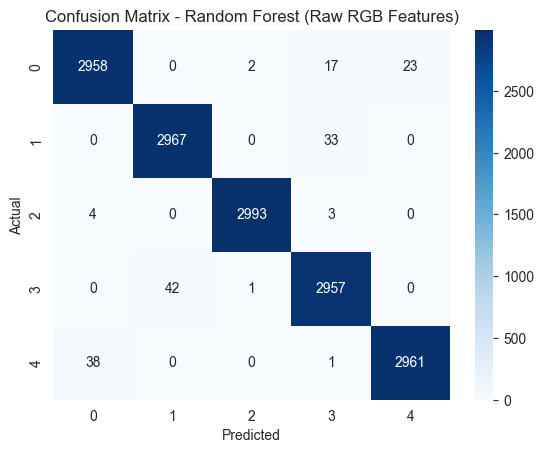


Support Vector Machine Classification Report:
              precision    recall  f1-score   support

     Arborio       0.53      1.00      0.69      3000
     Basmati       1.00      0.05      0.09      3000
      Ipsala       0.98      1.00      0.99      3000
     Jasmine       0.40      0.61      0.48      3000
   Karacadag       1.00      0.51      0.68      3000

    accuracy                           0.63     15000
   macro avg       0.78      0.63      0.59     15000
weighted avg       0.78      0.63      0.59     15000

Accuracy: 0.6333, Precision: 0.7811, Recall: 0.6333, F1-Score: 0.5857
Inference Time: 0.050687 seconds


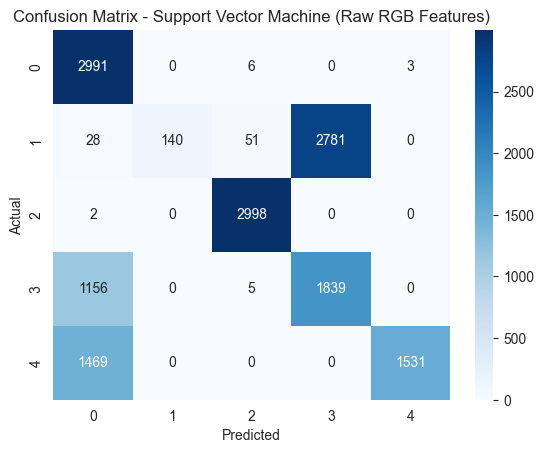

In [ ]:
# Evaluate models for raw RGB features
inference_times_raw = evaluate_models(best_models_raw, x_test_raw, y_test_raw, "Raw RGB")


Test Set Evaluation (Binary Thresholded Features):

K-Nearest Neighbors Classification Report:
              precision    recall  f1-score   support

     Arborio       0.92      0.93      0.92      3000
     Basmati       0.96      0.96      0.96      3000
      Ipsala       1.00      0.99      0.99      3000
     Jasmine       0.94      0.96      0.95      3000
   Karacadag       0.94      0.93      0.93      3000

    accuracy                           0.95     15000
   macro avg       0.95      0.95      0.95     15000
weighted avg       0.95      0.95      0.95     15000

Accuracy: 0.9521, Precision: 0.9522, Recall: 0.9521, F1-Score: 0.9521
Inference Time: 15.143004 seconds


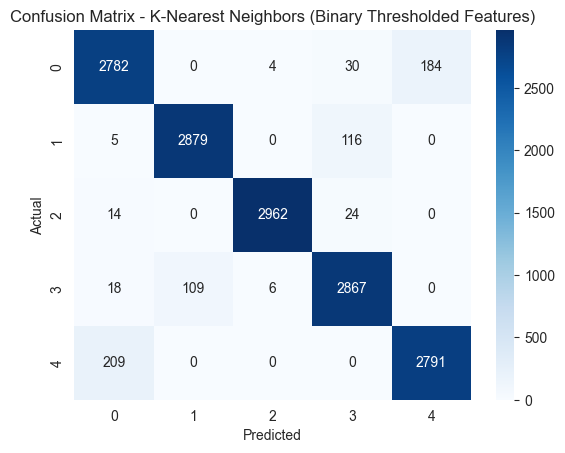


Random Forest Classification Report:
              precision    recall  f1-score   support

     Arborio       0.92      0.94      0.93      3000
     Basmati       0.97      0.97      0.97      3000
      Ipsala       1.00      0.99      0.99      3000
     Jasmine       0.95      0.96      0.96      3000
   Karacadag       0.94      0.93      0.94      3000

    accuracy                           0.96     15000
   macro avg       0.96      0.96      0.96     15000
weighted avg       0.96      0.96      0.96     15000

Accuracy: 0.9566, Precision: 0.9567, Recall: 0.9566, F1-Score: 0.9566
Inference Time: 0.281996 seconds


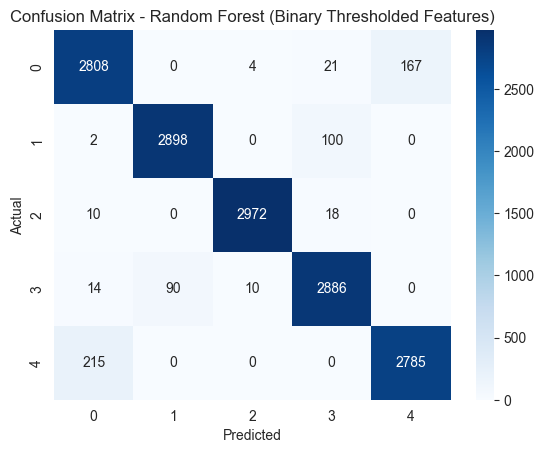


Support Vector Machine Classification Report:
              precision    recall  f1-score   support

     Arborio       0.91      0.91      0.91      3000
     Basmati       0.92      0.93      0.92      3000
      Ipsala       0.98      0.99      0.99      3000
     Jasmine       0.91      0.89      0.90      3000
   Karacadag       0.93      0.93      0.93      3000

    accuracy                           0.93     15000
   macro avg       0.93      0.93      0.93     15000
weighted avg       0.93      0.93      0.93     15000

Accuracy: 0.9316, Precision: 0.9314, Recall: 0.9316, F1-Score: 0.9315
Inference Time: 0.042005 seconds


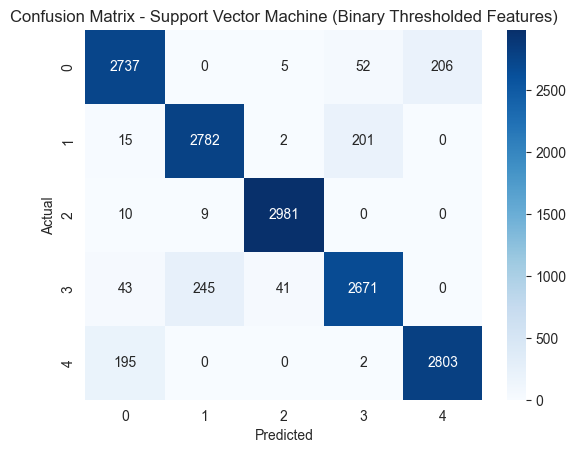

In [ ]:
# Evaluate models for binary thresholded features
inference_times_binary = evaluate_models(best_models_binary, x_test_binary, y_test_binary, "Binary Thresholded")

>Raw RGB Features

- Structure: The original pixel values (0-255 for each color channel) are reshaped into a flat array per image —preserving detailed color information.
- Advantage: High-dimensional, rich feature set allows complex models like Random Forest to capture nuanced patterns (e.g., texture, color gradients).
- Challenge: More data means longer inference times. SVM struggled due to high dimensionality, leading to poor performance.
- Use Case: Best for tasks where color differentiation is crucial.

> Binary Thresholded Features

- Structure: Each pixel is converted to 0 or 1 based on a 128 threshold —drastically reducing feature complexity.
- Advantage: Smaller, simpler data representation speeds up models.
- Challenge: Loss of gradient and color details affects accuracy.
- Use Case: Ideal for scenarios where shape/contrast matters more than color.

> Test Set Evaluation (Raw RGB Features):

- K-Nearest Neighbors Accuracy: 0.9775, Inference Time: 14.834177 seconds
- Random Forest: Accuracy: 0.9891, Inference Time: 0.450107 seconds
- Support Vector Machine: Accuracy: 0.6333, Inference Time: 0.050687 seconds

> Test Set Evaluation (Binary Thresholded Features):

- K-Nearest Neighbors: Accuracy: 0.9521, Inference Time: 15.143004 seconds
- Random Forest: Accuracy: 0.9566, Inference Time: 0.281996 seconds
- Support Vector Machine: Accuracy: 0.9316, Inference Time: 0.042005 seconds


In [ ]:
k_folds = KFold(n_splits = 5)

In [ ]:
# Cross-validate models for raw RGB features
cross_validate_models(best_models_raw, x_raw, labels, cv=k_folds)


Cross-Validation Results:

K-Nearest Neighbors
Cross Validation Scores:  [0.97666667 0.981      0.97946667 0.9772     0.97833333]
Average CV Score:  0.9785333333333334
Number of CV Scores used in Average:  5
Cross-Validation Accuracy: 0.9785 (±0.0016)

Random Forest
Cross Validation Scores:  [0.98913333 0.9912     0.98886667 0.98713333 0.98833333]
Average CV Score:  0.9889333333333333
Number of CV Scores used in Average:  5
Cross-Validation Accuracy: 0.9889 (±0.0013)

Support Vector Machine
Cross Validation Scores:  [0.99273333 0.99293333 0.9928     0.9926     0.99273333]
Average CV Score:  0.99276
Number of CV Scores used in Average:  5
Cross-Validation Accuracy: 0.9928 (±0.0001)


In [ ]:
# Cross-validate models for binary thresholded features
cross_validate_models(best_models_binary, x_binary, labels, cv=k_folds)


Cross-Validation Results:

K-Nearest Neighbors
Cross Validation Scores:  [0.952      0.95333333 0.9502     0.94846667 0.951     ]
Average CV Score:  0.951
Number of CV Scores used in Average:  5
Cross-Validation Accuracy: 0.9510 (±0.0016)

Random Forest
Cross Validation Scores:  [0.95666667 0.95686667 0.9542     0.9536     0.95786667]
Average CV Score:  0.95584
Number of CV Scores used in Average:  5
Cross-Validation Accuracy: 0.9558 (±0.0016)

Support Vector Machine
Cross Validation Scores:  [0.93466667 0.932      0.9328     0.9298     0.934     ]
Average CV Score:  0.9326533333333333
Number of CV Scores used in Average:  5
Cross-Validation Accuracy: 0.9327 (±0.0017)


1. Train-Test Split Results
- Pros: Faster to run, straightforward to interpret.
- Cons: Results depend heavily on how the data splits, one "lucky" or "unlucky" split can misrepresent performance.

- KNN (Raw): 97.75% accuracy, but slow inference (14.83s).
- Random Forest (Raw): 98.91% accuracy, faster (0.45s).
- SVM (Raw): Low accuracy (63.33%), fast (0.05s).

Binary features slightly reduced accuracy but improved SVM’s performance:

SVM (Binary): Jumped to 93.16% accuracy.


2. K-Fold Cross-Validation (5 folds)
- Pros: More reliable, trains and tests on different subsets multiple times, reducing bias from one lucky split.
- Cons: Takes longer to train due to multiple runs.

- KNN (Raw): Cross-validation accuracy 97.85 — more stable than the test split.
- Random Forest (Raw): 98.89 — still strong and consistent.
- SVM (Raw): 99.28 — surprisingly improved in CV, showing it generalized better than the test set suggested.

Binary Thresholded Features):

- KNN: 95.10 — slightly lower than the test split but still consistent across folds.
- Random Forest: 95.58 — slightly lower than the test split but still consistent.
- SVM: 93.27 — aligns with the test split performance, proving reliability.

In [ ]:
# Find the optimal models for raw data
best_model_raw = max(best_models_raw, key=lambda name: accuracy_score(y_test_raw, best_models_raw[name].predict(x_test_raw)))
fastest_inference_raw = min(inference_times_raw, key=inference_times_raw.get)

print("\nBest Model Based on Accuracy For Raw Data:", best_model_raw)
print("Fastest Model in Inference For Raw Data:", fastest_inference_raw, f"({inference_times_raw[fastest_inference_raw]:.6f} seconds)")


Best Model Based on Accuracy For Raw Data: Random Forest
Fastest Model in Inference For Raw Data: Support Vector Machine (0.050687 seconds)


In [ ]:
# Find the optimal models for binary data
best_model_binary = max(best_models_binary, key=lambda name: accuracy_score(y_test_binary, best_models_binary[name].predict(x_test_binary)))
fastest_inference_binary = min(inference_times_binary, key=inference_times_binary.get)

print("\nBest Model Based on Accuracy For Binary Data:", best_model_binary)
print("Fastest Model in Inference For Binary Data:", fastest_inference_binary, f"({inference_times_binary[fastest_inference_binary]:.6f} seconds)")


Best Model Based on Accuracy For Binary Data: Random Forest
Fastest Model in Inference For Binary Data: Support Vector Machine (0.042005 seconds)


> Random Forest emerges as the best model in terms of accuracy for both raw and binary data. This is because Random Forest combines multiple decision trees, reducing overfitting and improving generalization which is crucial for handling complex image data with noise or variation. It effectively captures patterns without relying on the pixel-level details alone, which helps maintain high accuracy across different feature types.


>On the other hand, Support Vector Machine (SVM) proves to be the fastest model in inference time for both raw and binary data. SVM's strength lies in finding an optimal hyperplane to separate classes, and once trained, the prediction phase involves only a quick computation of the decision boundary. This efficiency makes SVM suitable for tasks requiring real-time or near-instantaneous predictions, although its lower accuracy compared to Random Forest limits its reliability for this specific task.